In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


from xgbse.converters import convert_to_structured
from pycox.datasets import metabric

from xgbse.converters import convert_to_structured
from xgbse import XGBSEDebiasedBCE

In [2]:
# getting data
data = pd.read_parquet("data/data_with_feats_4xgb.parquet.gzip")
data = data.copy()

data.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,purpose_ohe_moving,purpose_ohe_other,purpose_ohe_renewable_energy,purpose_ohe_small_business,purpose_ohe_vacation,purpose_ohe_wedding,verification_status_ohe_Not Verified,verification_status_ohe_Source Verified,verification_status_ohe_Verified,fico_average
0,5000,36,10.65,162.87,7,10.0,24000.0,27.65,0,1,...,0,0,0,0,0,0,0,0,1,737.0
1,2500,60,15.27,59.83,14,0.0,30000.0,1.0,0,5,...,0,0,0,0,0,0,0,1,0,742.0
2,2400,36,15.96,84.33,15,10.0,12252.0,8.72,0,2,...,0,0,0,1,0,0,1,0,0,737.0
3,10000,36,13.49,339.31,11,10.0,49200.0,20.0,0,1,...,0,1,0,0,0,0,0,1,0,692.0
4,3000,60,12.69,67.79,10,1.0,80000.0,17.94,0,0,...,0,1,0,0,0,0,0,1,0,697.0


In [3]:
target_cols = [col for col in data.columns if "target" in col] + ['term']
target_cols

['target', 'target_month', 'target_xgb', 'term']

In [4]:
features = ["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "int_rate", "revol_util"]

features += [col for col in data.columns if "home_ownership_ohe_" in col]

data_used_cols = data[features + target_cols].dropna()
# assert data.shape[0] == data_used_cols.shape[0]

features

['annual_inc',
 'loan_amnt',
 'fico_average',
 'emp_length',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'sub_grade',
 'int_rate',
 'revol_util',
 'home_ownership_ohe_ANY',
 'home_ownership_ohe_MORTGAGE',
 'home_ownership_ohe_NONE',
 'home_ownership_ohe_OTHER',
 'home_ownership_ohe_OWN',
 'home_ownership_ohe_RENT']

In [5]:
# splitting to X, T, E format
X = data_used_cols.drop(['target', 'target_month', 'target_xgb'], axis=1)
T = data_used_cols['target_month']
E = data_used_cols['target']
y = convert_to_structured(T, E)

# splitting between train, and validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
TIME_BINS = np.arange(1, 61, 1)
TIME_BINS

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

In [6]:
X_train

,annual_inc,loan_amnt,fico_average,emp_length,acc_open_past_24mths,avg_cur_bal,sub_grade,int_rate,revol_util,home_ownership_ohe_ANY,home_ownership_ohe_MORTGAGE,home_ownership_ohe_NONE,home_ownership_ohe_OTHER,home_ownership_ohe_OWN,home_ownership_ohe_RENT,term
1610433,43000.0,3200,712.0,3.0,2,42372,14,14.99,32.1,0,1,0,0,0,0,36
374256,34000.0,14000,722.0,3.0,3,4775,11,12.61,33.2,0,1,0,0,0,0,60
119272,40000.0,15000,667.0,10.0,4,2189,13,15.22,87.7,0,1,0,0,0,0,36
1834976,55600.0,6000,692.0,2.0,1,36413,7,10.49,87.6,0,1,0,0,0,0,36
1489313,60000.0,24000,667.0,10.0,3,25093,13,13.67,56.7,0,1,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192117,42000.0,10000,687.0,4.0,1,4158,9,13.11,74.2,0,0,0,0,0,1,36
1031666,118000.0,14000,662.0,2.0,2,2235,7,9.17,58.5,0,0,0,0,0,1,36
157736,62000.0,10000,677.0,10.0,4,17776,10,14.09,89.8,0,1,0,0,0,0,36
1552925,55000.0,15000,677.0,4.0,3,3627,11,12.79,51.8,0,0,0,0,0,1,36


In [7]:
# fitting xgbse model
xgbse_model = XGBSEDebiasedBCE(
    xgb_params = {
        "objective": "survival:aft",
        "eval_metric": "aft-nloglik",
        "aft_loss_distribution": "normal",
        "aft_loss_distribution_scale": 1,
        "tree_method": "hist",
        "learning_rate": 0.025066311555882063,
        "max_depth": 9,
        "booster": "dart",
        "subsample": 0.6647914335903077,
        "min_child_weight": 50,
        "colsample_bynode": 0.5,
    },
    lr_params={'C': 0.001, 'max_iter': 1000}
)

In [8]:
X_train

,annual_inc,loan_amnt,fico_average,emp_length,acc_open_past_24mths,avg_cur_bal,sub_grade,int_rate,revol_util,home_ownership_ohe_ANY,home_ownership_ohe_MORTGAGE,home_ownership_ohe_NONE,home_ownership_ohe_OTHER,home_ownership_ohe_OWN,home_ownership_ohe_RENT,term
1610433,43000.0,3200,712.0,3.0,2,42372,14,14.99,32.1,0,1,0,0,0,0,36
374256,34000.0,14000,722.0,3.0,3,4775,11,12.61,33.2,0,1,0,0,0,0,60
119272,40000.0,15000,667.0,10.0,4,2189,13,15.22,87.7,0,1,0,0,0,0,36
1834976,55600.0,6000,692.0,2.0,1,36413,7,10.49,87.6,0,1,0,0,0,0,36
1489313,60000.0,24000,667.0,10.0,3,25093,13,13.67,56.7,0,1,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192117,42000.0,10000,687.0,4.0,1,4158,9,13.11,74.2,0,0,0,0,0,1,36
1031666,118000.0,14000,662.0,2.0,2,2235,7,9.17,58.5,0,0,0,0,0,1,36
157736,62000.0,10000,677.0,10.0,4,17776,10,14.09,89.8,0,1,0,0,0,0,36
1552925,55000.0,15000,677.0,4.0,3,3627,11,12.79,51.8,0,0,0,0,0,1,36


In [9]:
xgbse_model.fit(
    X_train.values, y_train, time_bins=TIME_BINS, num_boost_round=200
)

XGBSEDebiasedBCE(lr_params={'C': 0.001, 'max_iter': 1000},
                 xgb_params={'aft_loss_distribution': 'normal',
                             'aft_loss_distribution_scale': 1,
                             'booster': 'dart', 'colsample_bynode': 0.5,
                             'eval_metric': 'aft-nloglik',
                             'learning_rate': 0.025066311555882063,
                             'max_depth': 9, 'min_child_weight': 50,
                             'objective': 'survival:aft',
                             'subsample': 0.6647914335903077,
                             'tree_method': 'hist'})

<!-- XGBSEDebiasedBCE(lr_params={'C': 0.001, 'max_iter': 500},
                 xgb_params={'aft_loss_distribution': 'normal',
                             'aft_loss_distribution_scale': 1,
                             'booster': 'dart', 'colsample_bynode': 0.5,
                             'eval_metric': 'aft-nloglik',
                             'learning_rate': 0.025066311555882063,
                             'max_depth': 9, 'min_child_weight': 50,
                             'objective': 'survival:aft',
                             'subsample': 0.6647914335903077,
                             'tree_method': 'hist'}) -->

In [10]:
# XGBSEDebiasedBCE(lr_params={'C': 0.001, 'max_iter': 500},
#                  xgb_params={'aft_loss_distribution': 'normal',
#                              'aft_loss_distribution_scale': 1,
#                              'booster': 'dart', 'colsample_bynode': 0.5,
#                              'eval_metric': 'aft-nloglik',
#                              'learning_rate': 0.05, 'max_depth': 8,
#                              'min_child_weight': 50,
#                              'objective': 'survival:aft', 'subsample': 0.5,
#                              'tree_method': 'hist'})

In [11]:
# predicting
y_pred = xgbse_model.predict(X_test)

print(y_pred.shape)
y_pred.head()

(357731, 60)


,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,0.999988,0.999292,0.998241,0.997028,0.995719,0.994147,0.992322,0.989770,0.987221,0.984808,...,0.762692,0.761788,0.761094,0.760513,0.759989,0.759552,0.759204,0.758822,0.758531,0.758340
1,0.999988,0.998863,0.997275,0.994742,0.992446,0.989611,0.985565,0.981680,0.977488,0.973099,...,0.706859,0.705975,0.705229,0.704623,0.704074,0.703625,0.703280,0.702907,0.702615,0.702438
2,0.999987,0.996916,0.991795,0.984075,0.977203,0.968091,0.955720,0.944392,0.931219,0.919147,...,0.655783,0.654881,0.654013,0.653295,0.652724,0.652311,0.651923,0.651523,0.651270,0.651094
3,0.999987,0.989035,0.973633,0.952688,0.924947,0.889656,0.863787,0.834277,0.811752,0.777046,...,0.510771,0.509989,0.509292,0.508733,0.508193,0.507772,0.507503,0.507163,0.506872,0.506728
4,0.999987,0.997815,0.995701,0.992327,0.987852,0.984586,0.981597,0.977332,0.973323,0.969996,...,0.834309,0.833365,0.832617,0.831995,0.831415,0.830925,0.830546,0.830103,0.829777,0.829567


<AxesSubplot:>

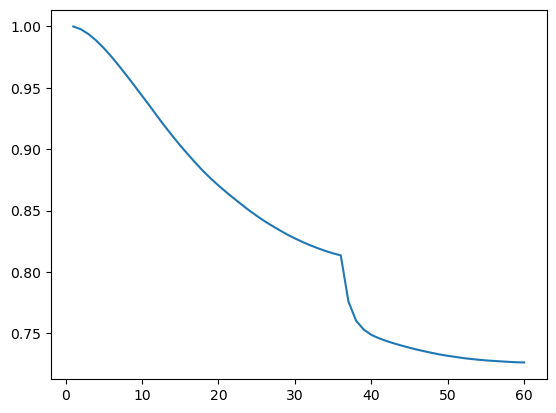

In [12]:
y_pred.mean().plot.line()

In [13]:
y_pred

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,0.999988,0.999292,0.998241,0.997028,0.995719,0.994147,0.992322,0.989770,0.987221,0.984808,...,0.762692,0.761788,0.761094,0.760513,0.759989,0.759552,0.759204,0.758822,0.758531,0.758340
1,0.999988,0.998863,0.997275,0.994742,0.992446,0.989611,0.985565,0.981680,0.977488,0.973099,...,0.706859,0.705975,0.705229,0.704623,0.704074,0.703625,0.703280,0.702907,0.702615,0.702438
2,0.999987,0.996916,0.991795,0.984075,0.977203,0.968091,0.955720,0.944392,0.931219,0.919147,...,0.655783,0.654881,0.654013,0.653295,0.652724,0.652311,0.651923,0.651523,0.651270,0.651094
3,0.999987,0.989035,0.973633,0.952688,0.924947,0.889656,0.863787,0.834277,0.811752,0.777046,...,0.510771,0.509989,0.509292,0.508733,0.508193,0.507772,0.507503,0.507163,0.506872,0.506728
4,0.999987,0.997815,0.995701,0.992327,0.987852,0.984586,0.981597,0.977332,0.973323,0.969996,...,0.834309,0.833365,0.832617,0.831995,0.831415,0.830925,0.830546,0.830103,0.829777,0.829567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357726,0.999987,0.997607,0.993751,0.989485,0.983497,0.976641,0.968061,0.957557,0.946170,0.934785,...,0.656582,0.655717,0.654744,0.654076,0.653502,0.653036,0.652672,0.652288,0.652021,0.651841
357727,0.999987,0.998326,0.996303,0.994121,0.991645,0.989438,0.987321,0.983928,0.981238,0.979010,...,0.867662,0.866797,0.866123,0.865450,0.864869,0.864385,0.863999,0.863579,0.863261,0.863045
357728,0.999988,0.996782,0.991933,0.986729,0.976624,0.965439,0.953681,0.942960,0.932967,0.920109,...,0.663005,0.662123,0.661469,0.660857,0.660329,0.659957,0.659589,0.659225,0.658964,0.658795
357729,0.999988,0.997676,0.994530,0.991491,0.987045,0.982723,0.978048,0.972580,0.967341,0.962442,...,0.816410,0.815447,0.814669,0.814042,0.813454,0.812968,0.812584,0.812169,0.811845,0.811636


In [14]:
# importing metrics
from xgbse.metrics import concordance_index, approx_brier_score

# running metrics
print(f"C-index: {concordance_index(y_test, y_pred)}")
# print(f"Avg. Brier Score: {approx_brier_score(y_test, y_pred)}")

C-index: 0.6843114772562473


C-index: 0.6843114772562473

In [18]:
from joblib import dump, load
dump(xgbse_model, "xgbse_model.pickle")

['xgbse_model.pickle']

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

results = cross_val_score(xgbse_model, X, y, scoring=make_scorer(concordance_index))
results